In [2]:
import gymnasium as gym
import gymnasium
gymnasium.__version__


from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback


import sys

import math
import os
import random
from collections import deque
from typing import Deque, Dict, List, Tuple

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output
from torch.nn.utils import clip_grad_norm_

# !curl -O https://raw.githubusercontent.com/curt-park/rainbow-is-all-you-need/master/segment_tree.py
# os.getcwd()
from utils.segment_tree import MinSegmentTree, SumSegmentTree

from utils.utils import *


# Simple DQN

In [15]:
env = gym.make("LunarLander-v3", render_mode="rgb_array")


In [23]:
env = gym.make("LunarLander-v3") 
env_val = gym.make("LunarLander-v3")

# Instantiate the agent
model = DQN(
    policy="MlpPolicy", 
    env=env, 
    verbose=0,
    buffer_size=50_000,
    learning_starts=1_000,
    target_update_interval=1_000,
    )

# Train the agent and display a progress bar
model.learn(
    total_timesteps=500_000, 
    progress_bar=True,
    callback=EvalCallback(
        env_val,
        best_model_save_path="./logs/dqn_lunar",
        log_path="./logs/dqn_lunar",
        eval_freq=50_000,
        render=False,
        deterministic=True,
        n_eval_episodes=10,
    ))

Output()

Eval num_timesteps=50000, episode_reward=52.12 +/- 65.88

Episode length: 979.80 +/- 31.58

New best mean reward!

Eval num_timesteps=100000, episode_reward=-67.57 +/- 25.86

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=150000, episode_reward=-48.43 +/- 41.22

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=200000, episode_reward=102.37 +/- 90.39

Episode length: 754.30 +/- 202.99

New best mean reward!

Eval num_timesteps=250000, episode_reward=135.62 +/- 79.08

Episode length: 800.00 +/- 192.86

New best mean reward!

Eval num_timesteps=300000, episode_reward=184.26 +/- 108.71

Episode length: 302.90 +/- 128.19

New best mean reward!

Eval num_timesteps=350000, episode_reward=131.15 +/- 113.73

Episode length: 283.00 +/- 142.44

Eval num_timesteps=400000, episode_reward=137.71 +/- 105.48

Episode length: 404.20 +/- 180.10

Eval num_timesteps=450000, episode_reward=99.96 +/- 83.67

Episode length: 654.50 +/- 348.71

Eval num_timesteps=500000, episode_reward=56.92 +/- 102.57

Episode length: 462.80 +/- 335.96

In [24]:
model = DQN.load("./logs/dqn_lunar/best_model", env=env)


In [25]:
mean_reward, std_reward = evaluate_policy(model, model.get_env(), n_eval_episodes=30)

print(f"Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

Mean reward: 195.57 +/- 71.07


In [28]:
scores = []
for _ in range(30):
    reward, _ = evaluate_policy(model, model.get_env(), n_eval_episodes=1)
    scores.append(reward)


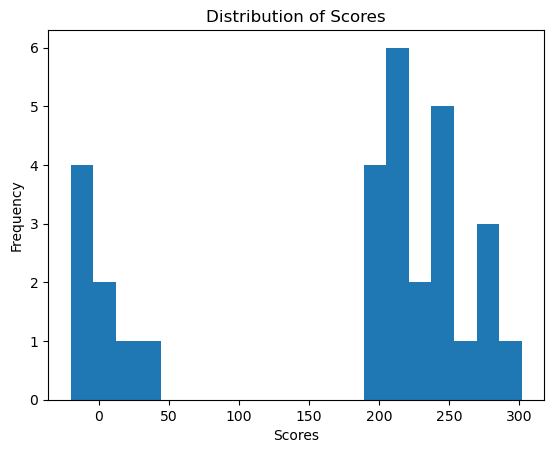

In [29]:
plt.hist(scores, bins=20)
plt.xlabel("Scores")
plt.ylabel("Frequency")
plt.title("Distribution of Scores")
plt.show()

In [30]:
success_rate = np.mean(np.array(scores) > 200)
print(f"Success rate (score > 200): {success_rate:.2f}")


Success rate (score > 200): 0.67


# Rainbow DQN

In [2]:
seed = 777

def seed_torch(seed):
    torch.manual_seed(seed)
    if torch.backends.cudnn.enabled:
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

np.random.seed(seed)
random.seed(seed)
seed_torch(seed)

In [3]:
import torch

print(torch.cuda.is_available())

False


In [4]:
env = gym.make("LunarLander-v3", render_mode="rgb_array")


Some default configurations: 
- n steps: 3 
- alpha: 0.2 / beta: 0.6

Adjusted configurations: 
- Learning rate: 1e-4 
- Remove seed from training and evaluation

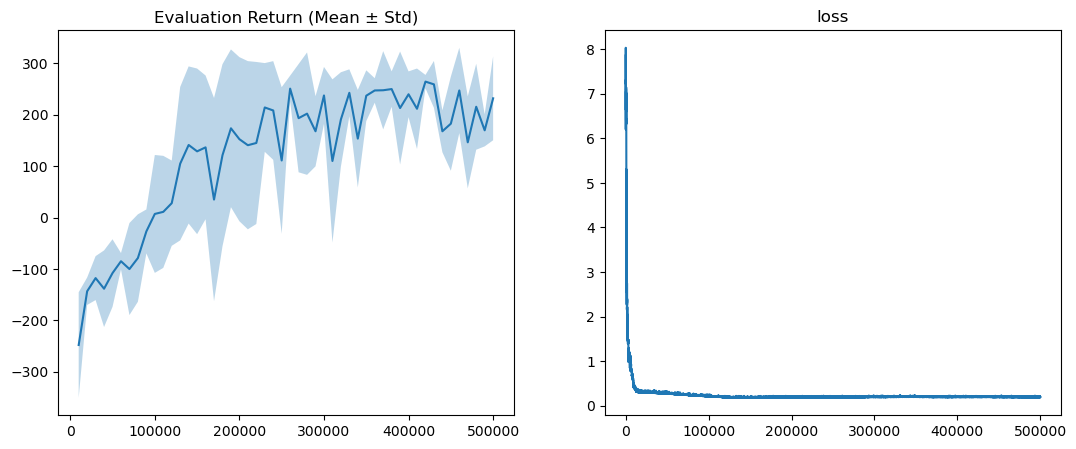

In [ ]:
agent = DQNAgent(
    env=env,
    memory_size=1_000_000, # 5000
    batch_size=128,
    target_update=1000,
    seed=seed,
    )

agent.train(500_000, plotting_interval=10_000)

In [11]:
mean, std = agent.evaluate(num_episodes=30, final_evaluate=True)
print(f"Mean reward: {mean:.2f} +/- {std:.2f}")

Mean reward: 262.36 +/- 49.81


In [8]:
video_folder="videos/rainbow"
agent.test(video_folder=video_folder)

/opt/anaconda3/lib/python3.12/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /Users/gasparpereira/Desktop/MSc Data Science/2 semestre/Reinforcement Learning/Projeto/Notebooks/videos/rainbow folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


score:  255.93007297935574


In [9]:
latest_file = show_latest_video(video_folder=video_folder)
print("Played:", latest_file)

Played: videos/rainbow/rl-video-episode-0.mp4


In [12]:
scores = []
for _ in range(30):
    score, _ = agent.evaluate(num_episodes=1, final_evaluate=True)
    scores.append(score)

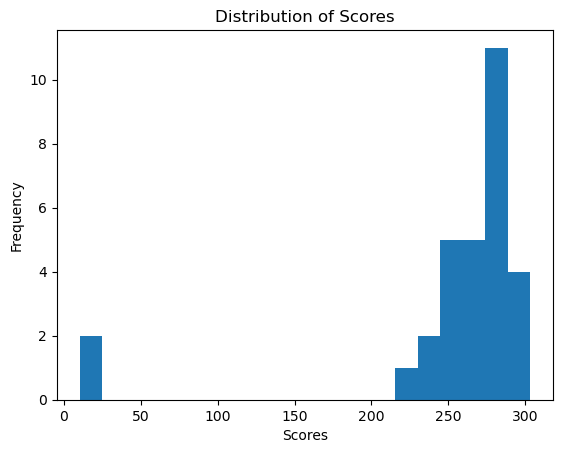

In [13]:
plt.hist(scores, bins=20)
plt.xlabel("Scores")
plt.ylabel("Frequency")
plt.title("Distribution of Scores")
plt.show()

In [14]:
success_rate = np.mean(np.array(scores) > 200)
print(f"Success rate (score > 200): {success_rate:.2f}")

Success rate (score > 200): 0.93


# Comparison graphs

In [ ]:
#### TRAINING PLOT ####
plot_df = pd.read_csv("logs/lunar_landing/evaluation_results.csv")

plot_df['moving_avg'] = plot_df['mean_return'].rolling(window=5).mean()
plot_df['moving_std'] = plot_df['std_return'].rolling(window=5).mean()

In [16]:
log_dir = "logs/dqn_lunar"
data = np.load(os.path.join(log_dir, "evaluations.npz"))

timesteps = data["timesteps"]
results = data["results"]

mean_returns = np.mean(results, axis=1)
std_returns = np.std(results, axis=1)

In [17]:
log_dir = "logs/dqn_lunar/PPO_logs"
data = pd.read_csv(os.path.join(log_dir, "eval_log.csv"))

data['moving_avg'] = data['mean_reward'].rolling(window=5).mean()
data['moving_std'] = data['std_reward'].rolling(window=5).mean()

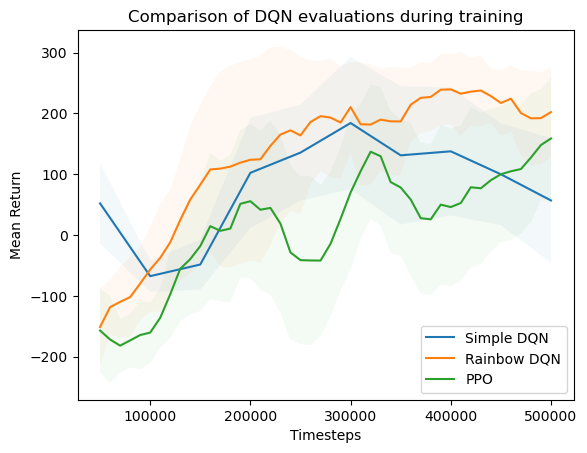

In [19]:
plt.plot(timesteps, mean_returns, label="Simple DQN")
plt.fill_between(timesteps, 
                 mean_returns - std_returns, 
                 mean_returns + std_returns, 
                 alpha=0.05)
plt.plot(plot_df["frame"], plot_df["moving_avg"], label="Rainbow DQN")
plt.fill_between(plot_df["frame"], 
                 np.array(plot_df["moving_avg"].to_list()) - np.array(plot_df["moving_std"].to_list()), 
                 np.array(plot_df["moving_avg"].to_list()) + np.array(plot_df["moving_std"].to_list()), 
                 alpha=0.05)
plt.plot(data['timesteps'], data['moving_avg'], label="PPO")
plt.fill_between(data['timesteps'],
                    data['moving_avg'] - data['moving_std'],
                    data['moving_avg'] + data['moving_std'],
                    alpha=0.05)
plt.legend()
plt.xlabel("Timesteps")
plt.ylabel("Mean Return")
plt.title("Comparison of DQN evaluations during training")
plt.show()